# Digit Recognizer

Simple implementation of a computer vision algorithm for learning and predicting labels on the MNIST dataset for the Kaggle competition of Digit Recognizer: https://www.kaggle.com/competitions/digit-recognizer

* Reading of the data
* Normalizing it
* Converting into matrix form
* Augment the data
    * By rotating the images
    * By zooming in/out of the images
* Learning through a Convolutional Neural Network
* Prediction on a test partition
* Evaluation of the learning process
* Performing the predictions on the unlabeled data
* Saving the predictions on disk
* Saving the model itself on disk (re-train it, etc.)

It returns and saves predictions on disk directly submittable into the competition.

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

2024-08-28 20:27:04.437592: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# White background in graphs
plt.style.use('dark_background')

# Dimensions of every pyplot figure. Change to suit your needs
plt.rcParams['figure.figsize'] = [10, 5]

# Read data

## If you have matrix-based data

In [3]:
#(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()
#train_images, test_images = train_images/255.0, test_images/255.0

In [4]:
train_images = pd.read_csv('train.csv')
test_images = pd.read_csv('test.csv')

In [5]:
template = pd.read_csv('sample_submission.csv')

In [6]:
train_labels = train_images['label']
train_images.drop(['label'], inplace = True, axis = 1)

In [7]:
# Normalize
train_images, test_images = train_images/255.0, test_images/255.0

In [8]:
Sequential = keras.models.Sequential
Dense = keras.layers.Dense
Conv2D = keras.layers.Conv2D
MaxPooling2D = keras.layers.MaxPooling2D
Flatten = keras.layers.Flatten
load_model = keras.models.load_model
AvgPooling2D = keras.layers.AveragePooling2D
Softmax = keras.layers.Softmax
Input = keras.layers.Input

### Convert into matrix-based

In [9]:
train_images, test_images = np.array(train_images), np.array(test_images)

In [10]:
channels = 1
train_nuevos, test_nuevos = [], []
for i in range(len(train_images)):
    train_nuevos.append(train_images[i].reshape(28,28,channels))
for i in range(len(test_images)):
    test_nuevos.append(test_images[i].reshape(28,28,channels))
train_nuevos, test_nuevos = np.array(train_nuevos), np.array(test_nuevos)
train_images, test_images = None, None

# Data augmentation

## Flipping

Flipping a strangely-written $5$ could lead to a very convincing $2$, for example. Since flipping could potentially lead to increasing the noise in the data, we leave this out, but this is something that can also be done.

In [10]:
#flipper = keras.layers.RandomFlip()
#train_flipped = flipper(train_nuevos)

## Rotating

In [17]:
rotator = keras.layers.RandomRotation(
    factor = (-0.1, 0.1),
    fill_mode = 'nearest'
)
train_rotated = rotator(train_nuevos)

## Random zoom

In [28]:
zoomer = tf.keras.layers.RandomZoom(
    -0.35, 0.35,
    fill_mode = 'nearest'
)
train_zoomed = zoomer(train_nuevos)

## Check the transformations done

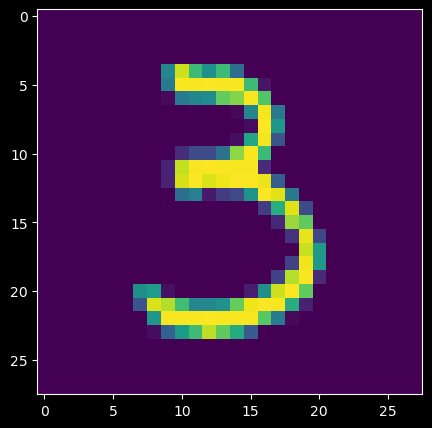

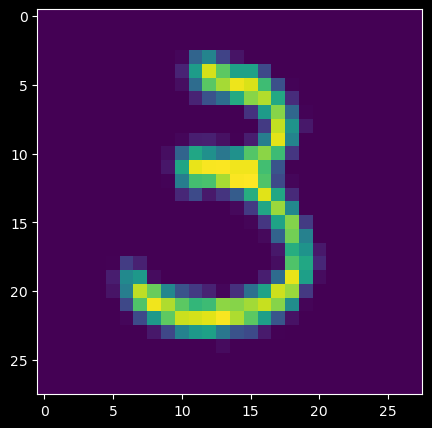

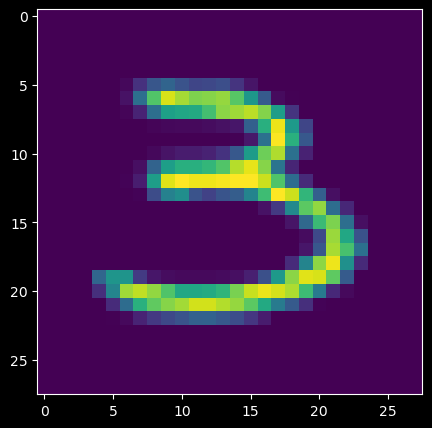

In [31]:
chosen = 4777
plt.imshow(train_nuevos[chosen])
plt.show()
plt.imshow(train_rotated[chosen])
plt.show()
plt.imshow(train_zoomed[chosen])
plt.show()

## Merge the augmentations

In [32]:
train_nuevos = np.concatenate((train_nuevos, train_rotated, train_zoomed), axis = 0)
#train_nuevos = np.concatenate((train_nuevos, train_rotated), axis = 0)
train_rotated = None
train_zoomed = None
#train_flipped = None

## Clone the labels

To compensate for the new data.

In [33]:
train_labels_augmented = pd.Series(3*list(train_labels))

# Split

In [34]:
from sklearn.model_selection import train_test_split as TTS
x_tr, x_te, y_tr, y_te = TTS(train_nuevos, train_labels_augmented, test_size = 0.25, random_state = None)

In [35]:
model = Sequential([
    Conv2D(256, (3,3), activation = 'gelu', input_shape = (28, 28, 1)),
    MaxPooling2D(2,2),
    Conv2D(256, (3,3), activation = 'gelu'),
    MaxPooling2D(2,2),
    Conv2D(256, (3,3), activation = 'gelu'),
    Flatten(),
    Dense(128, activation = 'gelu'),
    Dense(96, activation = 'gelu'),
    Dense(10, activation = 'linear'),
    Softmax()
])
model.summary()

/home/adan/.local/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 256)    │         2,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 11, 11, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 3, 3, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 96)             │        12,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │           970 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ softmax (Softmax)               │ (None, 10)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,491,114 (5.69 MB)

 Trainable params: 1,491,114 (5.69 MB)

 Non-trainable params: 0 (0.00 B)

In [36]:
model.compile(
    optimizer='adam',
    #optimizer='adamw',
    #loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), # False si la última capa es Softmax
    #loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    loss = 'sparse_categorical_crossentropy',
    #optimizer = 'rmsprop',
    #loss = 'binary_crossentropy', ## PARA CUANDO SOLO HAYA 2 CLASES!!!!
    metrics=['accuracy']
)

El método ```fit``` acepta ```generators``` aparte de las meras matrices de datos y las etiquetas. Esto permite entrenar un modelo sin tener que cargar todos los datos en memoria porque los ```generators``` devuelven solo una parte de los datos por paso.

Los ```generators``` contienen no solo los datos sino también las etiquetas. De no utilizarlos, hay que especificar también las etiquetas.

In [37]:
#nb_train_samples = len(train_generator.classes)
#nb_validation_samples = len(validation_generator.classes)

history = model.fit(
    x_tr, y_tr,
    validation_data = (x_te, y_te),
    callbacks = [
        keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 2) # Stop learning if val_loss doesn't change in 2 epochs
    ],
    #train_generator,
    #validation_data = validation_generator,
    #steps_per_epoch = 1000,
    #validation_steps = 400,
    epochs = 3
)

Epoch 1/3
2954/2954 ━━━━━━━━━━━━━━━━━━━━ 1637s 553ms/step - accuracy: 0.9175 - loss: 0.2574 - val_accuracy: 0.9817 - val_loss: 0.0614
Epoch 2/3
2954/2954 ━━━━━━━━━━━━━━━━━━━━ 1649s 558ms/step - accuracy: 0.9834 - loss: 0.0559 - val_accuracy: 0.9824 - val_loss: 0.0653
Epoch 3/3
2954/2954 ━━━━━━━━━━━━━━━━━━━━ 1625s 550ms/step - accuracy: 0.9868 - loss: 0.0430 - val_accuracy: 0.9864 - val_loss: 0.0500


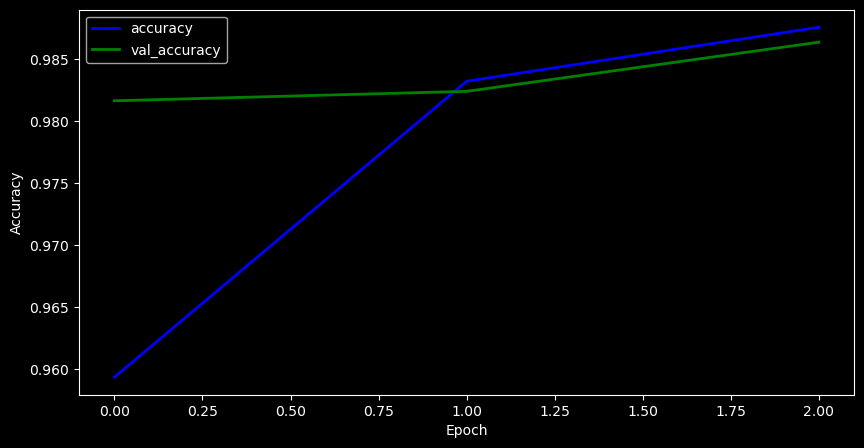

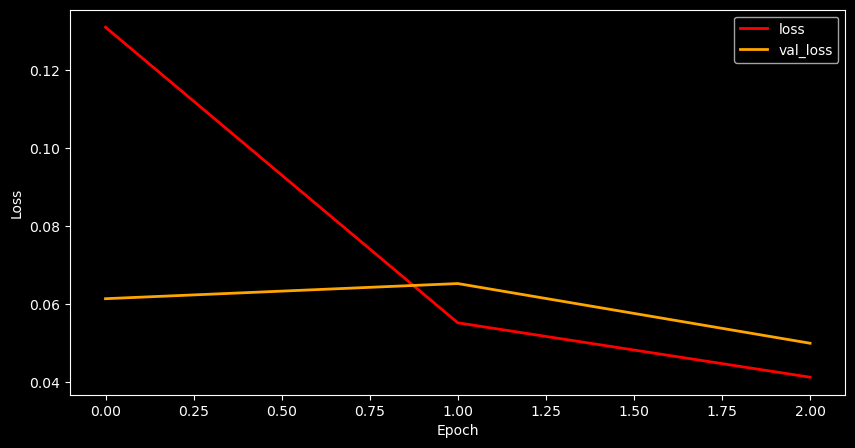

In [38]:
plt.plot(history.history['accuracy'], label='accuracy', linewidth = 2, color = 'blue')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy', linewidth = 2, color = 'green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.show()

plt.plot(history.history['loss'], label='loss', linewidth=2, color = 'red')
plt.plot(history.history['val_loss'], label='val_loss', linewidth=2, color = 'orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc = 'best')
plt.show()

In [39]:
#test_loss, test_acc = model.evaluate(validation_generator, verbose=2)
predicciones = model.predict(test_nuevos)
test_loss, test_acc = model.evaluate(x_te, y_te, verbose = 2)

875/875 ━━━━━━━━━━━━━━━━━━━━ 121s 139ms/step
985/985 - 132s - 134ms/step - accuracy: 0.9864 - loss: 0.0500


In [40]:
test_acc

0.986380934715271

In [52]:
model.save('Augmented_Train.keras')

In [43]:
lista = list(set(y_te))
clases_predecidas = []
for i in range(len(predicciones)):
    clases_predecidas.append(lista[list(predicciones[i]).index(max(list(predicciones[i])))])

In [44]:
template['Label'] = clases_predecidas

In [45]:
pd.DataFrame(template).to_csv('Results_submission.csv', index = False)

In [ ]:
#for i in range(len(test_labels)):
#    print (class_names[test_labels[i][0]], class_names[list(predicciones[i]).index(max(predicciones[i]))])